# Libraries

In [0]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.optimizers import Adam
from keras.optimizers import Adadelta
from keras.layers.core import Dropout
from keras.utils import np_utils
from keras import backend as K

# Modello continuo

## Data

In [0]:
# Import dataset
drive.mount('/content/drive')
train = np.genfromtxt('drive/My Drive/AML_TaxiTripDuration_Pennati_Rima_Rovera/Dataset/DatasetFinale.csv', delimiter=',', dtype='unicode')
train = train[1:,1:]

# Variabile target
tlabels = train[1:,6] #target per il modello continuo
tlabels2 = np_utils.to_categorical(train[1:,25]) #target per il modello discreto

# Rimozione dei valori aggiunti (meteo, distanze, zone, ...)
# OSS: si lascia la divisione della data in dayweek, month e hour (holidays no) e la distanza (20)
train = np.delete(train, [6,7,8,9,10,11,12,13,14,15,16,18,20,21,22,23,24,25,26], axis=1) 
train[1:,:] = train[1:,:].astype(float)

print(train[0,:])
    
# Z-score: outliers
z = np.abs(stats.zscore(train[1:,:].astype(float)))
a = np.where(z > 3.5) #3.5 soglia
b = np.where(z < -3.5)

# Z-score: Scalare i dati (ma non la variabile target)
train = preprocessing.scale(train[1:,:])

# Split del training set
train, validation, tlabels, vlabels = train_test_split(train[0:,:],
                                                       tlabels,
                                                       test_size = 0.25,
                                                       random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['hour' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'dayweek' 'month']


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U22 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## Modello

Train on 920460 samples, validate on 306820 samples
Epoch 1/30
920460/920460 [==============================] - 16s 17us/step - loss: 246.0368 - rmsle: 0.3680 - val_loss: 196.8654 - val_rmsle: 0.2856
Epoch 2/30
920460/920460 [==============================] - 14s 15us/step - loss: 215.0207 - rmsle: 0.3109 - val_loss: 192.4246 - val_rmsle: 0.2797
Epoch 3/30
920460/920460 [==============================] - 14s 15us/step - loss: 209.1727 - rmsle: 0.3021 - val_loss: 188.6777 - val_rmsle: 0.2742
Epoch 4/30
920460/920460 [==============================] - 14s 15us/step - loss: 205.4603 - rmsle: 0.2964 - val_loss: 186.1437 - val_rmsle: 0.2706
Epoch 5/30
920460/920460 [==============================] - 14s 15us/step - loss: 202.4379 - rmsle: 0.2918 - val_loss: 183.9337 - val_rmsle: 0.2692
Epoch 6/30
920460/920460 [==============================] - 14s 15us/step - loss: 199.8645 - rmsle: 0.2878 - val_loss: 182.4704 - val_rmsle: 0.2659
Epoch 7/30
920460/920460 [==============================] - 

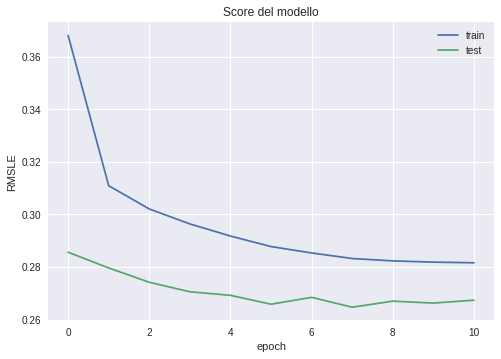

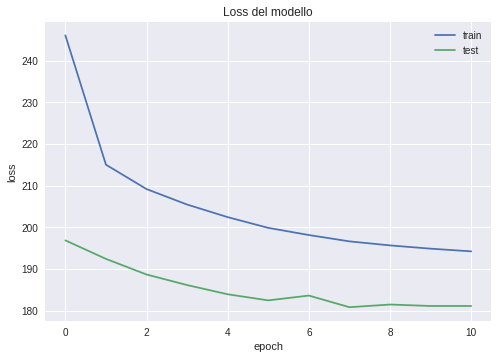

In [0]:
# Definire la metrica 'rmsle' (root mean square log error)
def rmsle(y_true, y_pred):
  y_pred = np.abs(y_pred + 1)
  y_true = np.abs(y_true + 1)
  return np.abs(K.sqrt(K.mean(K.square(K.log(y_pred)-K.log(y_true)),axis=-1)))

# Early stopping per la fase di training
early_stop = EarlyStopping(monitor='val_rmsle', patience=3, verbose=1) 

# Modello
finalmodel = Sequential()
finalmodel.add(Dense(54, input_dim=train.shape[1], activation='relu'))
finalmodel.add(Dense(20, activation='relu'))
finalmodel.add(Dropout(0.2))
finalmodel.add(Dense(1, activation='linear'))

# Compilazione 
finalmodel.compile(loss='mae', optimizer=Adam(lr=0.01), metrics=[rmsle])

# Training del modello continuo
h = finalmodel.fit(train, tlabels, validation_data=(validation,vlabels), epochs=30, batch_size=128, callbacks=[early_stop])

# Visualizzazione dei risultati
trainscore = h.history['rmsle'][len(h.history['rmsle'])-1]
valscore = h.history['val_rmsle'][len(h.history['val_rmsle'])-1]
print("RMSLE finale sul training set: ", np.round(trainscore,3))
print("RMSLE finale sul validation set: ", np.round(valscore,3))

# Plot per RMSLE
plt.plot(h.history['rmsle'])
plt.plot(h.history['val_rmsle'])
plt.title('Score del modello')
plt.ylabel('RMSLE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Plot per la loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Loss del modello')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Modello discreto

## Data

In [0]:
# Import dataset
drive.mount('/content/drive')
train = np.genfromtxt('drive/My Drive/AML_TaxiTripDuration_Pennati_Rima_Rovera/Dataset/DatasetFinale.csv', delimiter=',', dtype='unicode')
train = train[1:,1:]

# Variabile target
tlabels = np_utils.to_categorical(train[1:,25]) #target per il modello discreto

# Rimozione dei valori aggiunti (meteo, distanze, zone, ...)
# OSS: si lascia la divisione della data in dayweek, month e hour (holidays no) e distanza (20)
train = np.delete(train, [6,7,8,9,10,11,12,13,14,15,16,18,21,22,23,24,25,26], axis=1) 
train[1:,:] = train[1:,:].astype(float)

print(train[0,:])
    
# Z-score: outliers
z = np.abs(stats.zscore(train[1:,:].astype(float)))
a = np.where(z > 3.5) #3.5 soglia
b = np.where(z < -3.5)

# Z-score: Scalare i dati (ma non la variabile target)
train = preprocessing.scale(train[1:,:])

# Split del training set
train, validation, tlabels, vlabels = train_test_split(train[0:,:],
                                                       tlabels,
                                                       test_size = 0.25,
                                                       random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['hour' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'dayweek' 'month' 'distance']


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype <U22 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## Modello

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 75)                750       
_________________________________________________________________
dropout_2 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                760       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 55        
Total params: 1,565
Trainable params: 1,565
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 920460 samples, validate on 306820 samples
Epoch 1/30
920460/920460 [==============

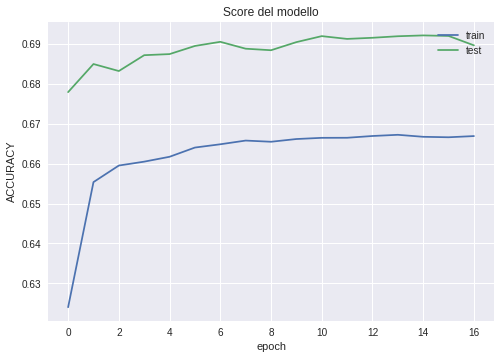

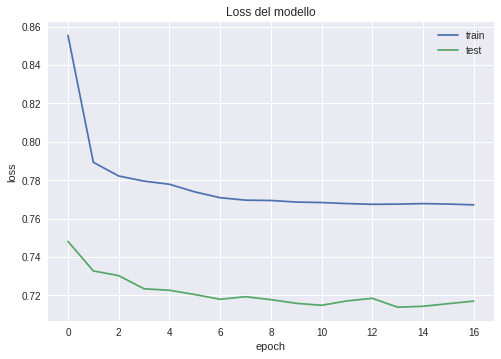

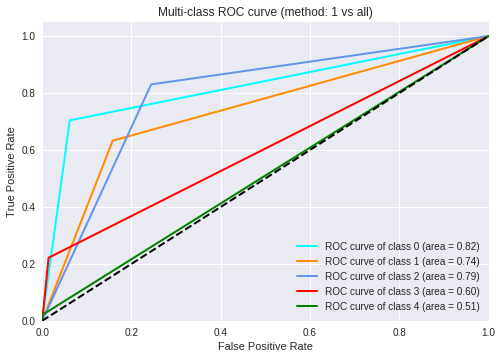

In [0]:
dims = train.shape[1]
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

model = Sequential()
model.add(Dense(75, input_shape=(dims,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10 , activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax')) 
model.summary()

model.compile(loss='categorical_crossentropy', 
              optimizer = Adadelta(lr = 1.050), 
              metrics=['accuracy'])

network_history = model.fit(train, tlabels, 
                            batch_size= 128, 
                            epochs = 30, 
                            verbose=1, 
                            validation_data=(validation, vlabels),
                            callbacks=[early_stop]) 

# Visualizzazione dei risultati
trainscore = network_history.history['acc'][len(network_history.history['acc'])-1]
valscore = network_history.history['val_acc'][len(network_history.history['val_acc'])-1]
print("ACCURACY finale sul training set: ", np.round(trainscore,3))
print("ACCURACY finale sul validation set: ", np.round(valscore,3))

# Plot per Accuracy
plt.plot(network_history.history['acc'])
plt.plot(network_history.history['val_acc'])
plt.title('Score del modello')
plt.ylabel('ACCURACY')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# Plot per la loss
plt.plot(network_history.history['loss'])
plt.plot(network_history.history['val_loss'])
plt.title('Loss del modello')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Predizioni 
preds = np_utils.to_categorical(model.predict_classes(validation))

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(vlabels[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(vlabels.ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve (method: 1 vs all)')
plt.legend(loc="lower right")
plt.show()